# This notebook is for the Fair-Shapely experiment

In [24]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [26]:
from src.data.unified_dataloader import load_dataset

a, processed_census_income_kdd = load_dataset('census_income_kdd')

age                                           0
workclass                                     0
industry_code                                 0
occupation_code                               0
education                                     0
wage_per_hour                                 0
enrolled_in_edu_inst_last_wk                  0
marital_status                                0
major_industry_code                           0
major_occupation_code                         0
race                                          0
hispanic_origin                               0
sex                                           0
member_of_a_labour_union                      0
reason_for_unemployment                       0
employment_status                             0
capital_gains                                 0
capital_losses                                0
dividend_from_stocks                          0
tax_filler_status                             0
region_of_previous_residence            

In [27]:
processed_census_income_kdd.head(3)

,age,wage_per_hour,capital_gains,capital_losses,dividend_from_stocks,instance_weight,num_persons_worked_for_employer,weeks_worked_in_year,sex,workclass_ Federal government,...,own_business_or_self_employed_2,fill_inc_questionnaire_for_veteran's_admin_ No,fill_inc_questionnaire_for_veteran's_admin_ Not in universe,fill_inc_questionnaire_for_veteran's_admin_ Yes,veterans_benefits_0,veterans_benefits_1,veterans_benefits_2,year_94,year_95,class
0,1.706939,-0.203989,-0.093502,-0.138177,-0.10222,-0.043817,-0.843184,-0.970621,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
1,1.030500,-0.203989,-0.093502,-0.138177,-0.10222,-0.691534,-0.421771,1.158280,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
2,-0.773339,-0.203989,-0.093502,-0.138177,-0.10222,-0.753246,-0.843184,-0.970621,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1


### 3. Split label/unlabel data, split train/test data.

In [28]:
'''census income kdd dataset'''
sampled_data = processed_census_income_kdd.sample(frac=0.1, random_state=42)
df = sampled_data.copy()
X = df.drop('class', axis=1)
y = df['class']



# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (20025, 505)
X_test shape: (8583, 505)


### 4. Train the original model

In [29]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9335896539671443


In [30]:
X_train['sex'].value_counts()

sex
0.0    10343
1.0     9682
Name: count, dtype: int64

In [31]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 0
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 1
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [32]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.07860329002141953
original_train_DR: 0.08025502413511276


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

In [33]:
'''
只考虑替换shapley value > 0.1 的值
'''

'\n只考虑替换shapley value > 0.1 的值\n'

2. 初始化FairnessExplainer
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 340
shapely value中大于0.1的值的个数有: 126


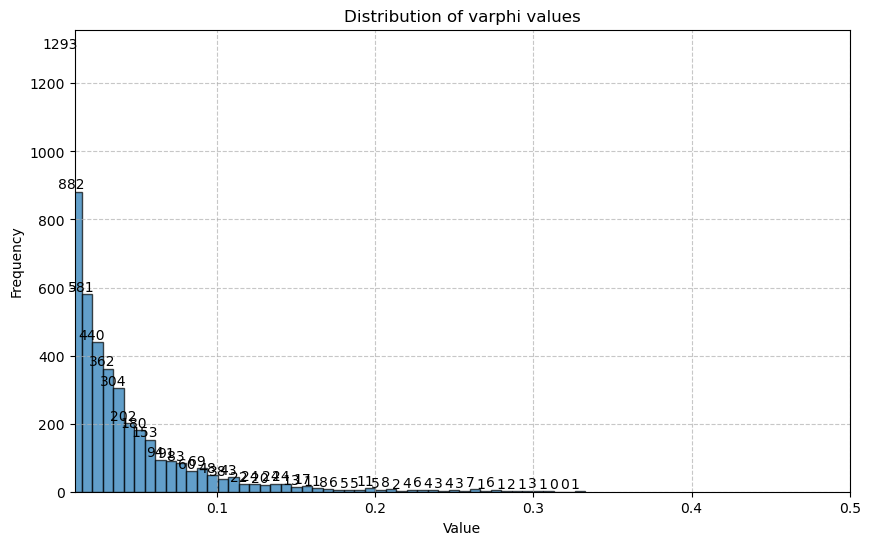

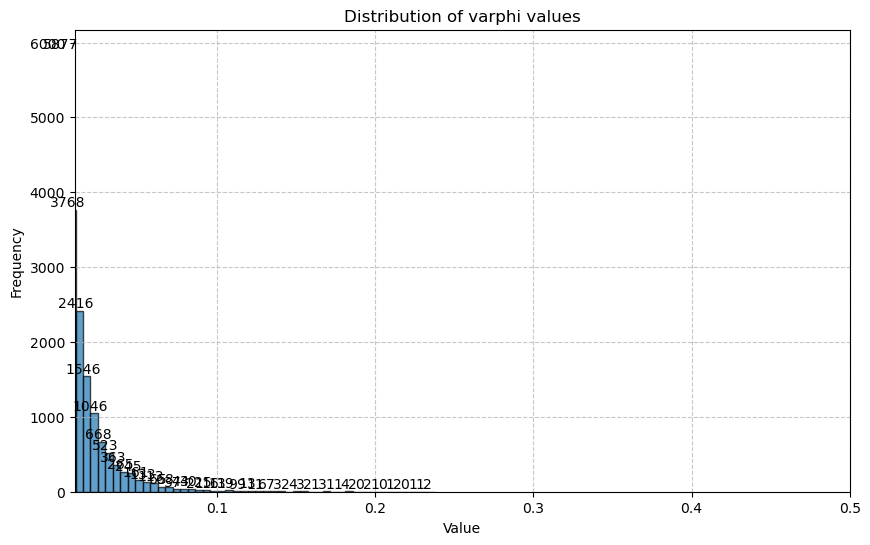

6. 开始整理并且合并新数据,共修改466个数据点, 使用new training set训练新模型
changed_value_info.shape: 465


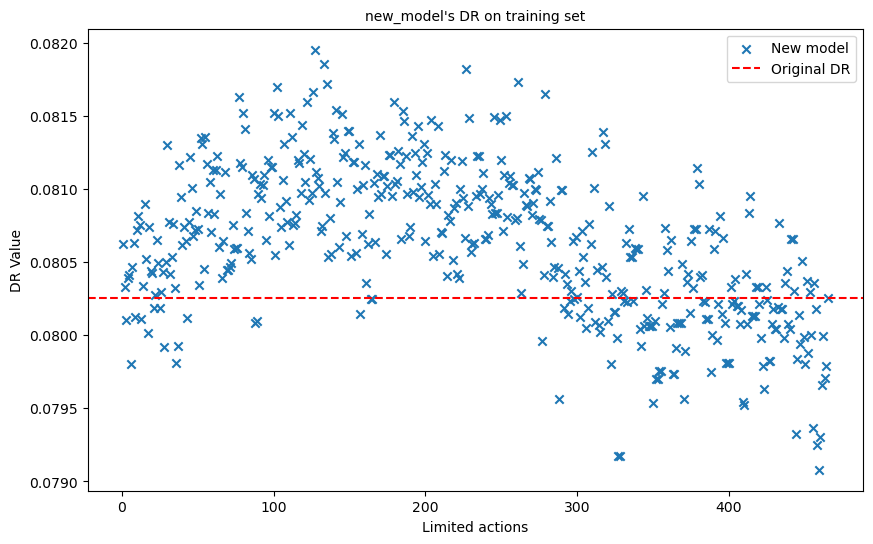

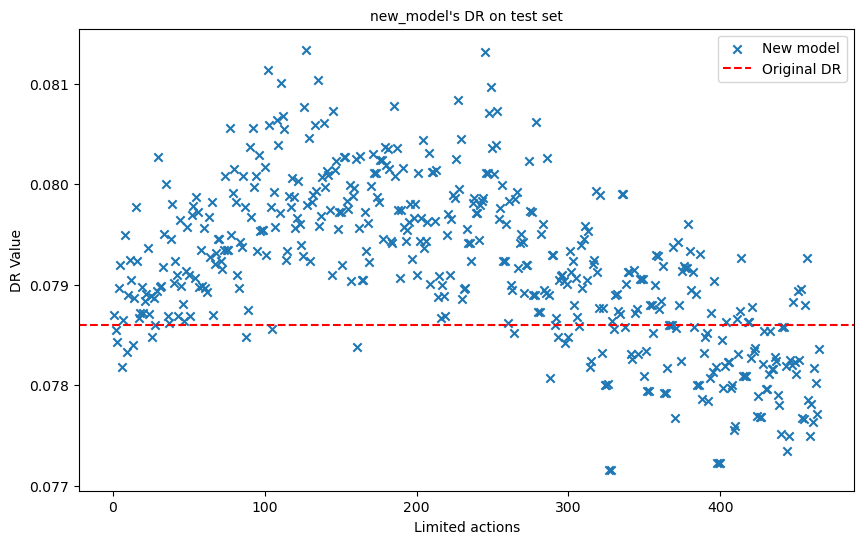

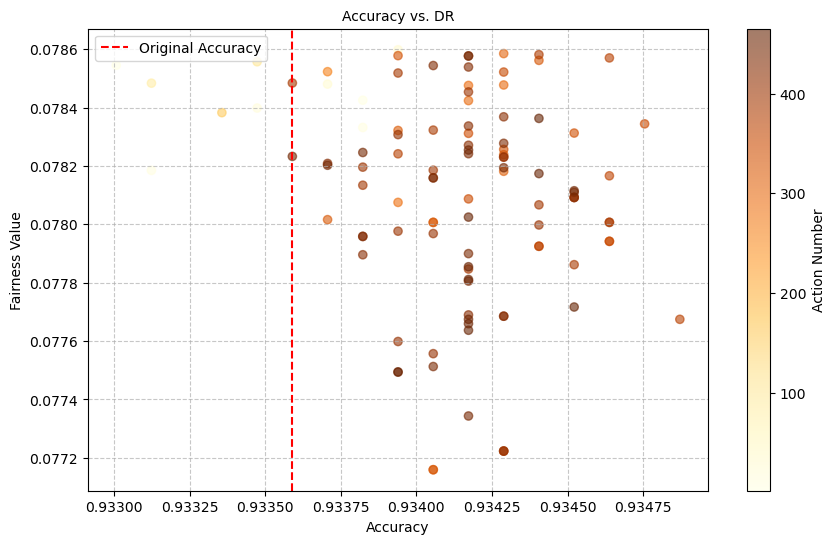

([0.07869607,
  0.0785453,
  0.07842543,
  0.07896783,
  0.07920087,
  0.07818493,
  0.07865294,
  0.079490766,
  0.078331925,
  0.07889443,
  0.07925083,
  0.079049036,
  0.0783986,
  0.07886815,
  0.079777695,
  0.0792409,
  0.0786724,
  0.07871733,
  0.07897469,
  0.078717634,
  0.07883396,
  0.07890547,
  0.07936924,
  0.07871197,
  0.078887686,
  0.07848067,
  0.07886827,
  0.07859843,
  0.07893369,
  0.08026782,
  0.078973494,
  0.07898718,
  0.079180375,
  0.0795059,
  0.0800044,
  0.07869094,
  0.07862298,
  0.07945788,
  0.07980722,
  0.07901279,
  0.07923727,
  0.079099566,
  0.07868684,
  0.079642564,
  0.07898922,
  0.07880986,
  0.07863699,
  0.07913206,
  0.07957453,
  0.079092346,
  0.078688785,
  0.07969354,
  0.079786845,
  0.079070136,
  0.07987459,
  0.07972311,
  0.07898201,
  0.079340816,
  0.07899168,
  0.07956421,
  0.07896608,
  0.07892414,
  0.07967045,
  0.07927418,
  0.07982343,
  0.07869451,
  0.07920234,
  0.07931111,
  0.079458326,
  0.079458326,
  0.07923

In [34]:
from src.experiments_approach2 import ExperimentNew
from src.experiments_approach3 import ExperimentNew2
''' 改变minority group中的部分特征值'''

experiment = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='census_income',
                            change_group = 'minority')
experiment.run_experiment()


2. 初始化FairnessExplainer
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 21
shapely value中大于0.1的值的个数有: 343


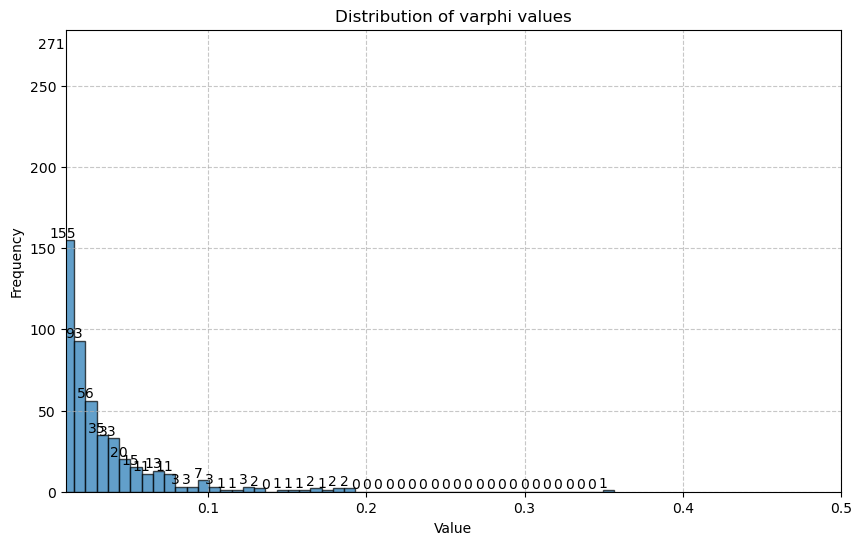

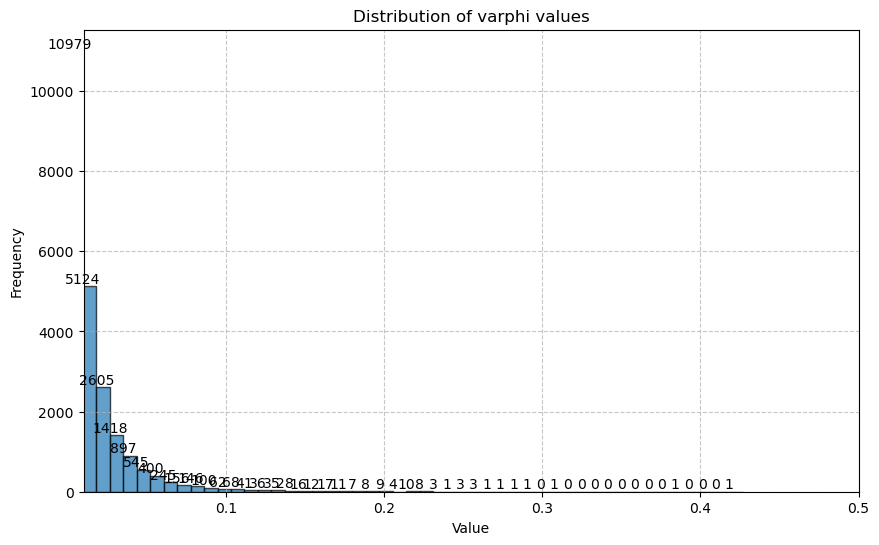

6. 开始整理并且合并新数据,共修改364个数据点, 使用new training set训练新模型
changed_value_info.shape: 363


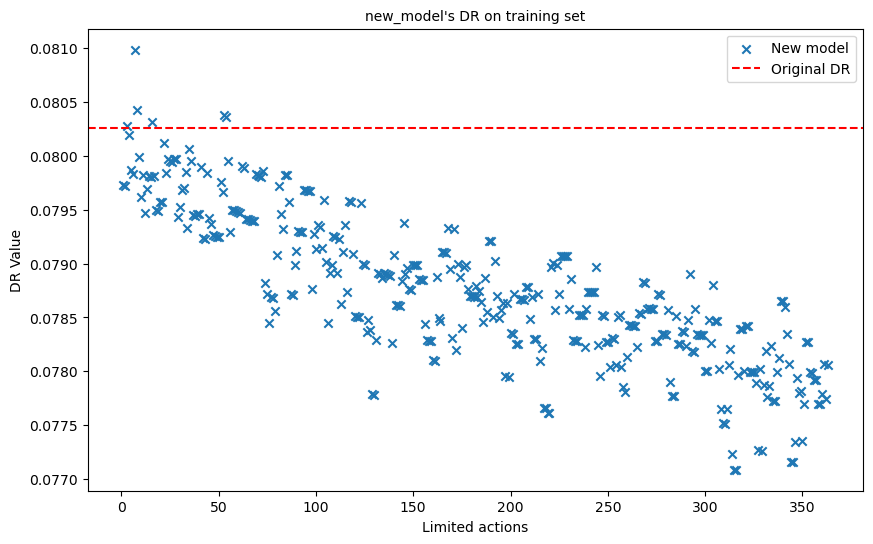

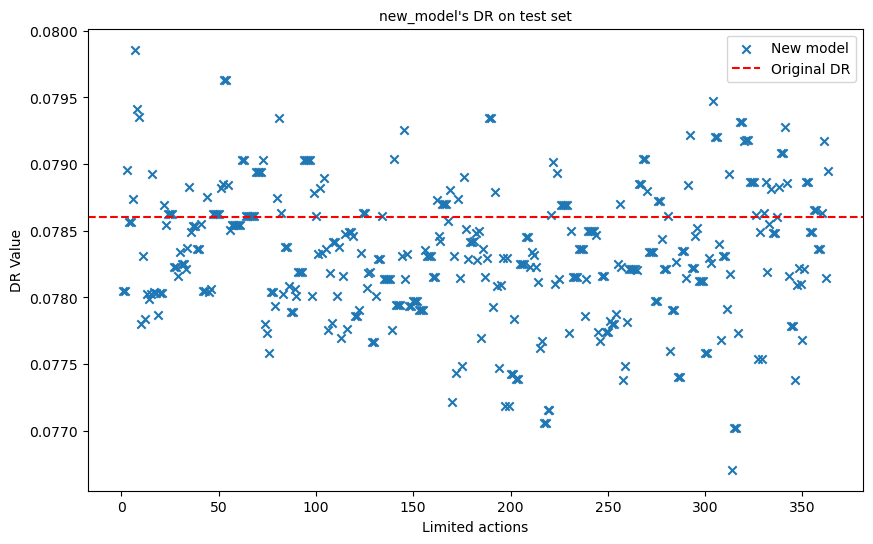

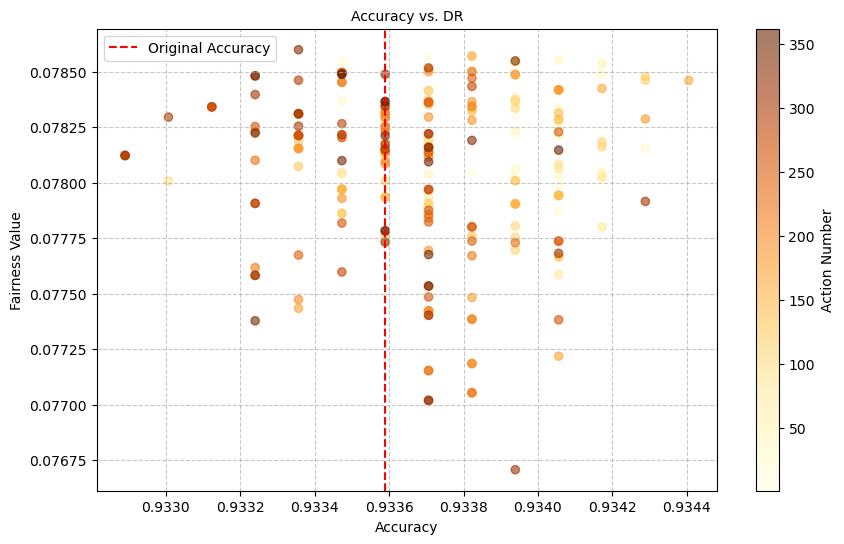

([0.0780468,
  0.0780468,
  0.078959055,
  0.078569435,
  0.07856286,
  0.07873903,
  0.07985829,
  0.079412386,
  0.07935633,
  0.07780093,
  0.07830906,
  0.077837385,
  0.07802886,
  0.0779891,
  0.07802636,
  0.07892323,
  0.07803802,
  0.07803285,
  0.07787023,
  0.07803434,
  0.07803434,
  0.07869025,
  0.078545,
  0.07862477,
  0.07862456,
  0.07862452,
  0.078229465,
  0.07823034,
  0.078158244,
  0.07833952,
  0.07825075,
  0.07825042,
  0.07821392,
  0.07836746,
  0.07882557,
  0.07848957,
  0.078537814,
  0.07853771,
  0.078366324,
  0.078366324,
  0.0785531,
  0.07804673,
  0.078046136,
  0.07875333,
  0.07803796,
  0.07806109,
  0.078623265,
  0.078623265,
  0.078623265,
  0.078623265,
  0.078818336,
  0.07885076,
  0.079633944,
  0.07963396,
  0.07884339,
  0.078507595,
  0.078546435,
  0.078546435,
  0.078546435,
  0.078546435,
  0.07854662,
  0.07903379,
  0.07903376,
  0.07861375,
  0.07861379,
  0.07861388,
  0.07861388,
  0.07861388,
  0.078938015,
  0.07893835,
  0.

In [35]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='census_income',
                            change_group = 'majority')
experiment2.run_experiment()